# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2023-10-08 10:28:20--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2023-10-08 10:28:20 (26.5 MB/s) - ‘cifar.py’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


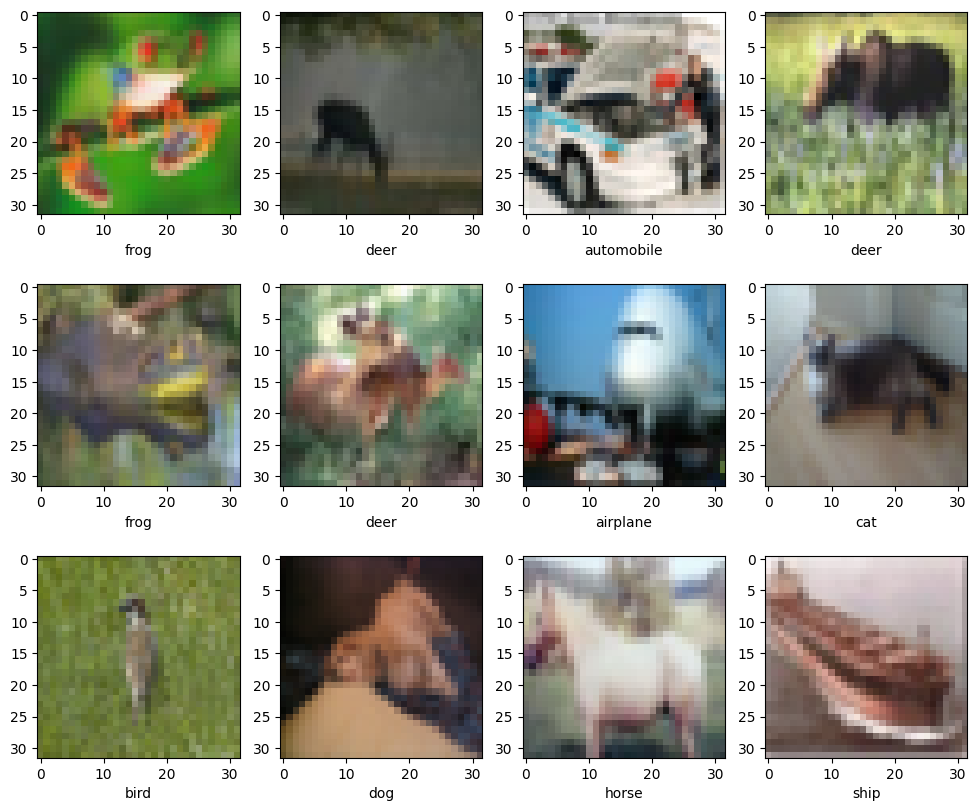

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [6]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

In [7]:
device = 'cuda'

In [8]:
model.to(device)

Sequential(
  (flatten): Flatten()
  (dense1): Linear(in_features=3072, out_features=64, bias=True)
  (dense1_relu): ReLU()
  (dense2_logits): Linear(in_features=64, out_features=10, bias=True)
)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [9]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [10]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3008, device='cuda:0', grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [11]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [13]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.113s
  training loss (in-iteration): 	2.025912
  validation accuracy: 			32.77 %
Epoch 2 of 100 took 1.069s
  training loss (in-iteration): 	1.859758
  validation accuracy: 			37.22 %
Epoch 3 of 100 took 1.067s
  training loss (in-iteration): 	1.791674
  validation accuracy: 			36.61 %
Epoch 4 of 100 took 1.060s
  training loss (in-iteration): 	1.741152
  validation accuracy: 			38.79 %
Epoch 5 of 100 took 1.059s
  training loss (in-iteration): 	1.698509
  validation accuracy: 			41.50 %
Epoch 6 of 100 took 1.126s
  training loss (in-iteration): 	1.660633
  validation accuracy: 			41.24 %
Epoch 7 of 100 took 1.100s
  training loss (in-iteration): 	1.633368
  validation accuracy: 			42.68 %
Epoch 8 of 100 took 1.058s
  training loss (in-iteration): 	1.607895
  validation accuracy: 			43.02 %
Epoch 9 of 100 took 1.056s
  training loss (in-iteration): 	1.586208
  validation accuracy: 			44.17 %
Epoch 10 of 100 took 1.052s
  training loss (in-iteration): 	1.568499
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [14]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		50.52 %
Achievement unlocked: 60lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [13]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=3),
    nn.ReLU(),
    Flatten(),
    nn.Linear(10 * 10 * 10, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
).to(device)


In [14]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2771, device='cuda:0', grad_fn=<MeanBackward0>)

In [15]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 2.590s
  training loss (in-iteration): 	1.795411
  validation accuracy: 			44.68 %
Epoch 2 of 20 took 1.516s
  training loss (in-iteration): 	1.544332
  validation accuracy: 			48.20 %
Epoch 3 of 20 took 1.621s
  training loss (in-iteration): 	1.448964
  validation accuracy: 			49.89 %
Epoch 4 of 20 took 1.542s
  training loss (in-iteration): 	1.381755
  validation accuracy: 			51.14 %
Epoch 5 of 20 took 1.527s
  training loss (in-iteration): 	1.318965
  validation accuracy: 			53.13 %
Epoch 6 of 20 took 1.530s
  training loss (in-iteration): 	1.263604
  validation accuracy: 			54.17 %
Epoch 7 of 20 took 1.570s
  training loss (in-iteration): 	1.227666
  validation accuracy: 			54.84 %
Epoch 8 of 20 took 1.600s
  training loss (in-iteration): 	1.189638
  validation accuracy: 			55.37 %
Epoch 9 of 20 took 1.534s
  training loss (in-iteration): 	1.157820
  validation accuracy: 			56.02 %
Epoch 10 of 20 took 1.848s
  training loss (in-iteration): 	1.130065
  validation 

In [16]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		55.44 %
Achievement unlocked: 60lvl Warlock!


In [17]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
).to(device)

In [18]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3288, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
import time
num_epochs = 14 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 14 took 1.584s
  training loss (in-iteration): 	1.689993
  validation accuracy: 			49.51 %
Epoch 2 of 14 took 1.603s
  training loss (in-iteration): 	1.403951
  validation accuracy: 			52.87 %
Epoch 3 of 14 took 1.613s
  training loss (in-iteration): 	1.315218
  validation accuracy: 			54.92 %
Epoch 4 of 14 took 1.589s
  training loss (in-iteration): 	1.245595
  validation accuracy: 			57.13 %
Epoch 5 of 14 took 1.606s
  training loss (in-iteration): 	1.195173
  validation accuracy: 			57.73 %
Epoch 6 of 14 took 1.648s
  training loss (in-iteration): 	1.146560
  validation accuracy: 			57.79 %
Epoch 7 of 14 took 1.586s
  training loss (in-iteration): 	1.102906
  validation accuracy: 			58.81 %
Epoch 8 of 14 took 1.596s
  training loss (in-iteration): 	1.070992
  validation accuracy: 			58.92 %
Epoch 9 of 14 took 1.599s
  training loss (in-iteration): 	1.042551
  validation accuracy: 			60.23 %
Epoch 10 of 14 took 1.844s
  training loss (in-iteration): 	1.009972
  validation 

In [20]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		59.30 %
Achievement unlocked: 60lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [21]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
).to(device)

In [22]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.7434, device='cuda:0', grad_fn=<MeanBackward0>)

In [23]:
import time
num_epochs = 13 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 13 took 1.923s
  training loss (in-iteration): 	1.380220
  validation accuracy: 			56.36 %
Epoch 2 of 13 took 1.925s
  training loss (in-iteration): 	1.118294
  validation accuracy: 			58.28 %
Epoch 3 of 13 took 1.905s
  training loss (in-iteration): 	1.008739
  validation accuracy: 			61.03 %
Epoch 4 of 13 took 1.935s
  training loss (in-iteration): 	0.922978
  validation accuracy: 			61.46 %
Epoch 5 of 13 took 1.963s
  training loss (in-iteration): 	0.849148
  validation accuracy: 			61.90 %
Epoch 6 of 13 took 2.135s
  training loss (in-iteration): 	0.783882
  validation accuracy: 			63.07 %
Epoch 7 of 13 took 1.898s
  training loss (in-iteration): 	0.733696
  validation accuracy: 			60.87 %
Epoch 8 of 13 took 1.879s
  training loss (in-iteration): 	0.673359
  validation accuracy: 			63.13 %
Epoch 9 of 13 took 1.934s
  training loss (in-iteration): 	0.634881
  validation accuracy: 			63.36 %
Epoch 10 of 13 took 2.044s
  training loss (in-iteration): 	0.591213
  validation 

In [24]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		60.03 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [25]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [26]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: Plese use this code in your training loop

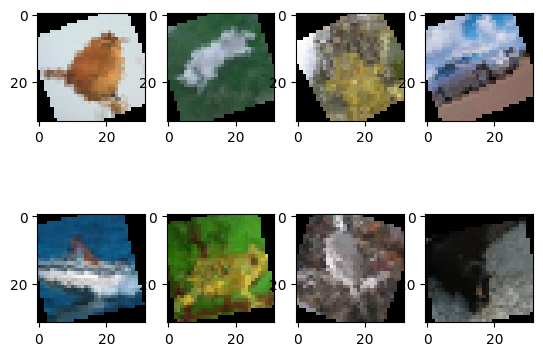

In [27]:
for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )


    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [40]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10(root="./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, batch_size=32, shuffle=False, num_workers=2)

In [38]:
from torch.utils.data import DataLoader, random_split


full_train_dataset = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_batch_gen = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_batch_gen = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [41]:
import time
num_epochs = 20 # total amount of full passes over training data

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        y_batch = y_batch.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 23.320s
  training loss (in-iteration): 	1.242360
  validation accuracy: 			58.92 %
Epoch 2 of 20 took 23.714s
  training loss (in-iteration): 	1.237205
  validation accuracy: 			59.16 %
Epoch 3 of 20 took 24.188s
  training loss (in-iteration): 	1.247032
  validation accuracy: 			59.39 %
Epoch 4 of 20 took 24.485s
  training loss (in-iteration): 	1.226609
  validation accuracy: 			58.05 %
Epoch 5 of 20 took 23.397s
  training loss (in-iteration): 	1.231528
  validation accuracy: 			58.45 %
Epoch 6 of 20 took 24.391s
  training loss (in-iteration): 	1.233411
  validation accuracy: 			59.61 %
Epoch 7 of 20 took 23.682s
  training loss (in-iteration): 	1.226580
  validation accuracy: 			59.58 %
Epoch 8 of 20 took 24.102s
  training loss (in-iteration): 	1.226487
  validation accuracy: 			59.92 %
Epoch 9 of 20 took 23.141s
  training loss (in-iteration): 	1.232480
  validation accuracy: 			59.30 %
Epoch 10 of 20 took 23.805s
  training loss (in-iteration): 	1.221266
  v

In [42]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    y_batch = y_batch.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		65.35 %
Achievement unlocked: 70lvl Warlock!


(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

# Step 1 After 60%
Regard previous nn as baseline, it reaches 60%, so expand it, add one more conv layer

In [48]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),  
    
    Flatten(),
    nn.Linear(32 * 16 * 16, 10)  
).to(device)


In [49]:
import time
num_epochs = 50 # total amount of full passes over training data

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        y_batch = y_batch.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 50 took 25.565s
  training loss (in-iteration): 	1.614316
  validation accuracy: 			43.95 %
Epoch 2 of 50 took 25.708s
  training loss (in-iteration): 	1.436398
  validation accuracy: 			47.23 %
Epoch 3 of 50 took 25.336s
  training loss (in-iteration): 	1.354034
  validation accuracy: 			52.25 %
Epoch 4 of 50 took 24.979s
  training loss (in-iteration): 	1.285284
  validation accuracy: 			53.75 %
Epoch 5 of 50 took 25.545s
  training loss (in-iteration): 	1.225870
  validation accuracy: 			54.78 %
Epoch 6 of 50 took 25.679s
  training loss (in-iteration): 	1.216670
  validation accuracy: 			57.06 %
Epoch 7 of 50 took 25.578s
  training loss (in-iteration): 	1.179641
  validation accuracy: 			57.69 %
Epoch 8 of 50 took 25.508s
  training loss (in-iteration): 	1.155070
  validation accuracy: 			58.66 %
Epoch 9 of 50 took 24.962s
  training loss (in-iteration): 	1.146948
  validation accuracy: 			58.89 %
Epoch 10 of 50 took 25.560s
  training loss (in-iteration): 	1.128157
  v

In [50]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    y_batch = y_batch.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		71.77 %
Achievement unlocked: 80lvl Warlock!


# Step 2 After 70%

It reaches 70%, double the size of nn, and due to the increasing size of nn, add more neurons 

In [51]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),


    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),


    Flatten(),
    nn.Linear(64 * 8 * 8, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 10)
).to(device)


In [52]:
import time
num_epochs = 50 # total amount of full passes over training data

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        y_batch = y_batch.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 50 took 27.605s
  training loss (in-iteration): 	1.367383
  validation accuracy: 			51.41 %
Epoch 2 of 50 took 26.809s
  training loss (in-iteration): 	1.154619
  validation accuracy: 			58.67 %
Epoch 3 of 50 took 27.381s
  training loss (in-iteration): 	1.040688
  validation accuracy: 			61.62 %
Epoch 4 of 50 took 27.699s
  training loss (in-iteration): 	0.981797
  validation accuracy: 			65.59 %
Epoch 5 of 50 took 27.796s
  training loss (in-iteration): 	0.940347
  validation accuracy: 			68.64 %
Epoch 6 of 50 took 28.153s
  training loss (in-iteration): 	0.894114
  validation accuracy: 			69.12 %
Epoch 7 of 50 took 27.915s
  training loss (in-iteration): 	0.858189
  validation accuracy: 			70.36 %
Epoch 8 of 50 took 28.086s
  training loss (in-iteration): 	0.837930
  validation accuracy: 			72.48 %
Epoch 9 of 50 took 29.307s
  training loss (in-iteration): 	0.821610
  validation accuracy: 			73.27 %
Epoch 10 of 50 took 29.251s
  training loss (in-iteration): 	0.794033
  v

In [53]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    y_batch = y_batch.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		84.47 %
Achievement unlocked: 110lvl Warlock!


# Step 3 After 80%

It reaches 80%, triple the size of nn, increase neurons

In [56]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    Flatten(),
    nn.Linear(128 * 4 * 4, 256), 
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 10)
).to(device)

In [57]:
import time
num_epochs = 50 # total amount of full passes over training data

opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        y_batch = y_batch.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 50 took 28.636s
  training loss (in-iteration): 	1.340454
  validation accuracy: 			53.72 %
Epoch 2 of 50 took 28.867s
  training loss (in-iteration): 	1.112762
  validation accuracy: 			60.70 %
Epoch 3 of 50 took 28.919s
  training loss (in-iteration): 	0.970335
  validation accuracy: 			66.36 %
Epoch 4 of 50 took 28.647s
  training loss (in-iteration): 	0.895642
  validation accuracy: 			68.91 %
Epoch 5 of 50 took 29.139s
  training loss (in-iteration): 	0.836615
  validation accuracy: 			72.52 %
Epoch 6 of 50 took 29.988s
  training loss (in-iteration): 	0.783782
  validation accuracy: 			72.42 %
Epoch 7 of 50 took 29.959s
  training loss (in-iteration): 	0.759442
  validation accuracy: 			74.17 %
Epoch 8 of 50 took 29.373s
  training loss (in-iteration): 	0.717413
  validation accuracy: 			75.31 %
Epoch 9 of 50 took 29.513s
  training loss (in-iteration): 	0.683240
  validation accuracy: 			75.55 %
Epoch 10 of 50 took 28.599s
  training loss (in-iteration): 	0.666098
  v

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795aa3bedbd0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x795aa3bedbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can

Epoch 45 of 50 took 29.015s
  training loss (in-iteration): 	0.377594
  validation accuracy: 			83.81 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795aa3bedbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795aa3bedbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch 46 of 50 took 29.764s
  training loss (in-iteration): 	0.377276
  validation accuracy: 			84.44 %
Epoch 47 of 50 took 28.650s
  training loss (in-iteration): 	0.373089
  validation accuracy: 			83.94 %
Epoch 48 of 50 took 28.526s
  training loss (in-iteration): 	0.362153
  validation accuracy: 			84.30 %
Epoch 49 of 50 took 28.503s
  training loss (in-iteration): 	0.361350
  validation accuracy: 			84.14 %
Epoch 50 of 50 took 27.153s
  training loss (in-iteration): 	0.366154
  validation accuracy: 			84.25 %


In [58]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    y_batch = y_batch.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		87.74 %
Achievement unlocked: 110lvl Warlock!
